In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import prettytable as pt
from matplotlib import pyplot as plt
import os 
import warnings
warnings.filterwarnings("ignore")

###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################

directory = os.path.normpath(os.getcwd() + os.sep + os.pardir+ os.sep + os.pardir)
datadirectory=directory+"/data/yielddata/yielddata.csv"
confdir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
configdirectory=confdir+"/samplecurves/config"


yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 


In [2]:
yieldcurveconfig=configdirectory+"/usd3m.json"
f = open (yieldcurveconfig, "r")
usd3ml = json.loads(f.read())
usd3ml

{'settlementDays': 2,
 'intpMethod': 'linear',
 'currency': 'USD',
 'calendar': 'UnitedStates',
 'dayCounter': 'Thirty360',
 'period': '3M',
 'instruments': {'DEPO': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360'},
  'FUTURES': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360',
   'market': 'IMM',
   'usedates': False},
  'IRS': {'businessDayConvention': 'Following',
   'dayCounter': 'Thirty360',
   'frequency': 'Semiannual'}}}

In [3]:
yieldcurve =  {
    "valuationDate": "2019-10-14",
    "yieldCurve":usd3ml ,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, yieldcurve,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [4]:
datelist=['2019-10-16','2019-10-21','2020-03-18','2020-06-18','2020-09-17','2020-12-16','2021-03-17',
                     '2021-06-16','2021-10-18','2022-10-17','2023-10-16','2024-10-16','2025-10-16','2026-10-16',
                     '2027-10-18','2028-10-16','2029-10-16','2030-10-16','2031-10-16','2034-10-16','2039-10-17',
                     '2044-10-17','2049-10-18','2059-10-16','2069-10-16']

In [5]:
yieldcurve =  {
    "valuationDate": "2019-10-14",
    "zeroRates": {
    "analysisDates":datelist,
        "compounding": "Compounded",
        "frequency": "Semiannual",
        "dayCounter":"Thirty360"
    },
    "discountRates": {
        "analysisDates":datelist},
    "yieldCurve":usd3ml,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, yieldcurve,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [6]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovayieldcurvedicts = {}
rhoovayieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovayieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovayieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    

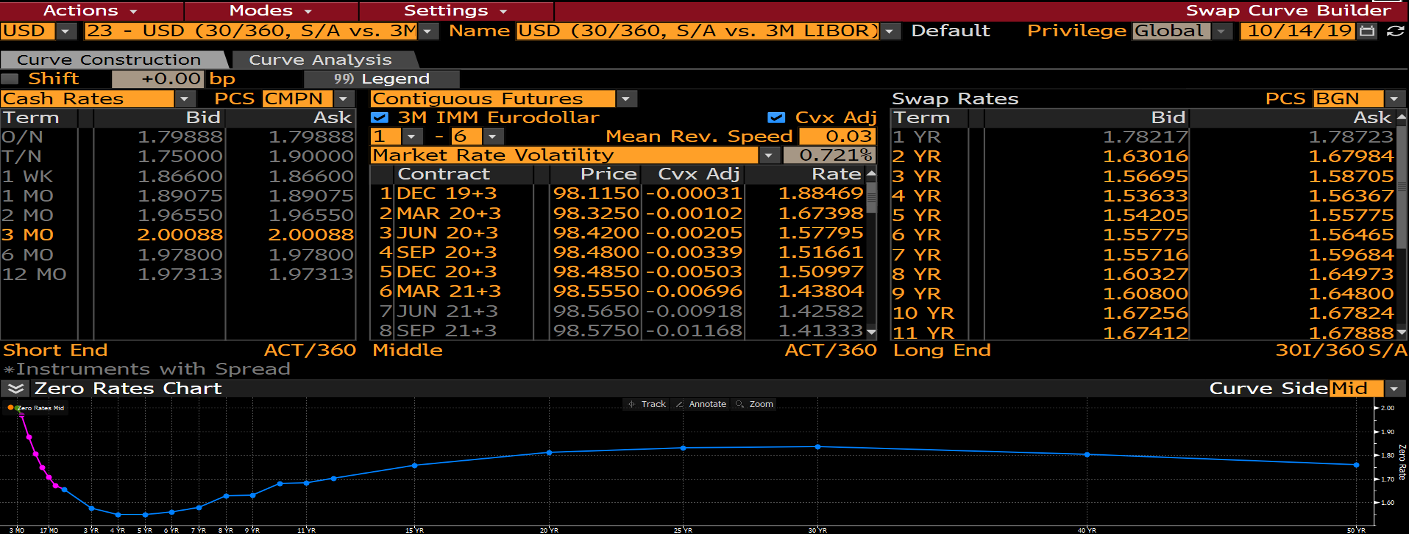

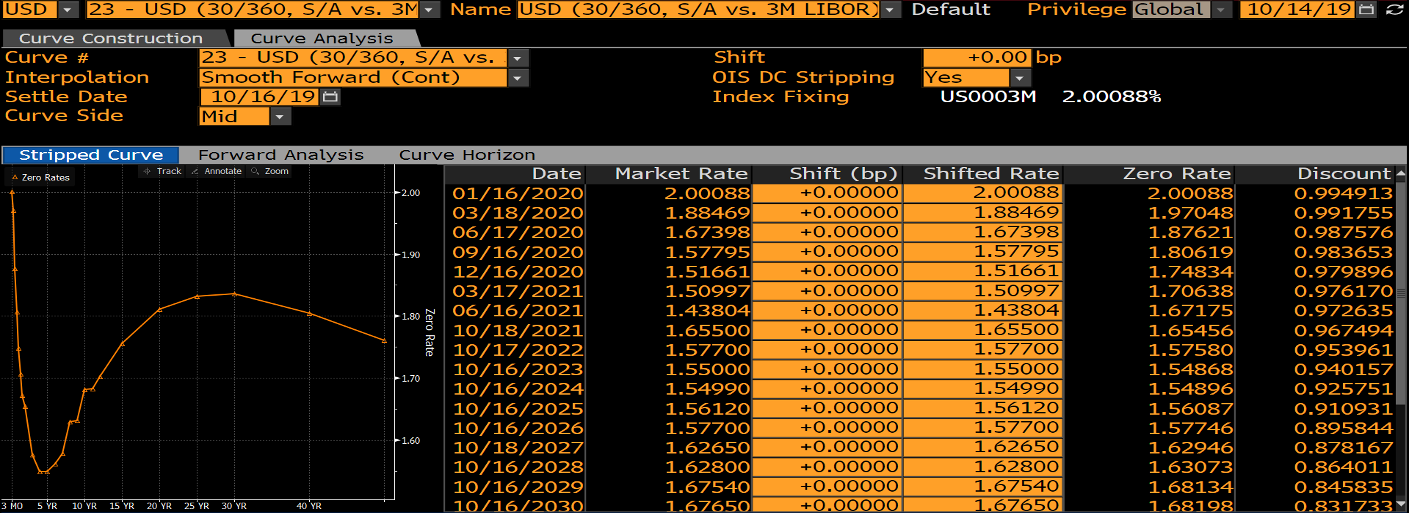

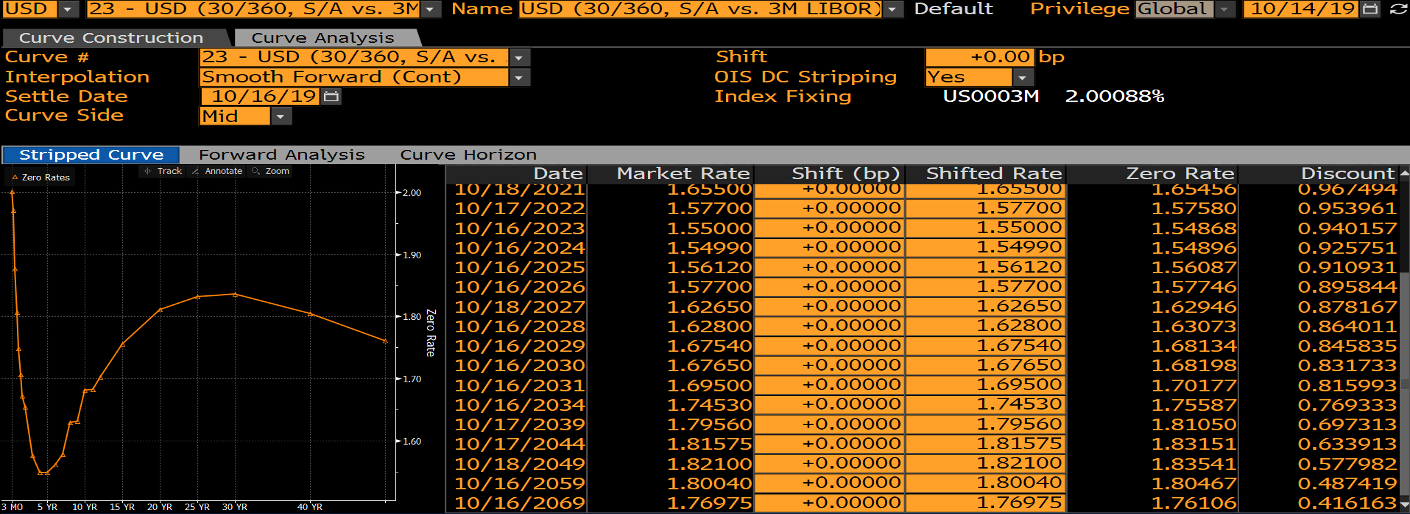

In [7]:
bloombergzerorates=[2.0505,2.0088,1.97048,1.87621,1.80619,1.74834,1.70638,1.67175,1.65456,1.57580,1.54868,1.54896,
                   1.56087,1.57746,1.62946,1.63073,1.68134,1.68198,1.70177,1.75587,1.81050,1.83151,1.83541,
                   1.80467,1.76106]
bloombergdiscountrates=[1,0.994913,0.991755,0.987576,0.983653,0.979896,0.976170,0.972635,0.967494,0.953961,0.9401757,
                        0.925751,0.910931,0.895844,0.878167,0.864011,0.845835,0.831733,0.815993,0.769333,0.697313,
                        0.633913,0.577982,0.487419,0.416163]

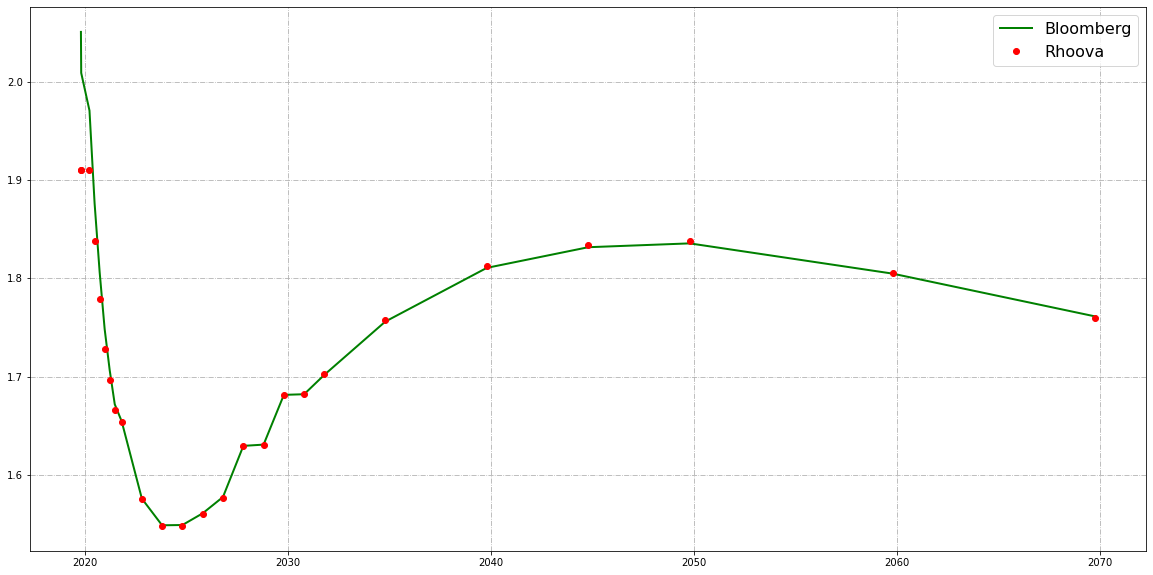

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvedicts.keys())
y1 =bloombergzerorates
y2 = list(rhoovayieldcurvedicts.values())


ax.plot(x,y1, 'g', label='Bloomberg', linewidth=2)
ax.plot(x,y2, 'ro', label='Rhoova', linewidth=4)
#
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

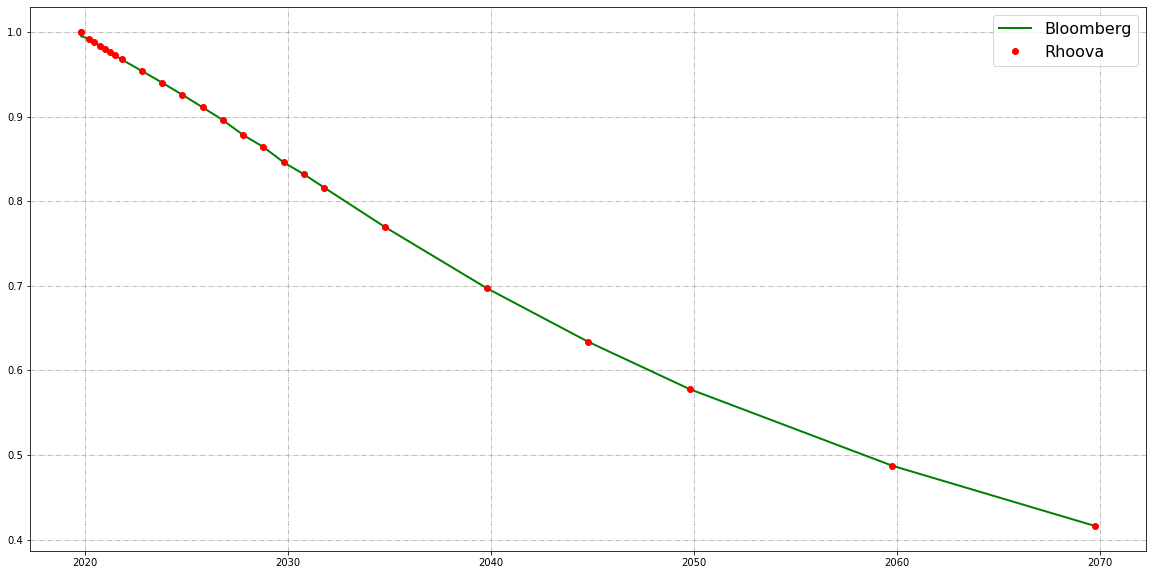

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvediscounts.keys())
y1 =bloombergdiscountrates
y2 = list(rhoovayieldcurvediscounts.values())

ax.plot(x,y1, 'g', label='Bloomberg', linewidth=2)
ax.plot(x,y2, 'ro', label='Rhoova', linewidth=12)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

In [10]:
pTable = pt.PrettyTable(['Maturity','Rhoova ZeroRates','Bloomberg ZR','Rhoova Discount Rate','Bloomberg DR'])
i=0
for key, val in rhoovayieldcurvedicts.items():
    pTable.add_row([key, val,bloombergzerorates[i],rhoovayieldcurvediscounts.get(key),bloombergdiscountrates[i]])
    i=i+1
pTable.align = 'c'
pTable.float_format = '.6'
print(pTable)

+------------+------------------+--------------+----------------------+--------------+
|  Maturity  | Rhoova ZeroRates | Bloomberg ZR | Rhoova Discount Rate | Bloomberg DR |
+------------+------------------+--------------+----------------------+--------------+
| 2019-10-16 |     1.910485     |   2.050500   |          1           |      1       |
| 2019-10-21 |     1.910485     |   2.008800   |       0.999736       |   0.994913   |
| 2020-03-18 |     1.910485     |   1.970480   |       0.992004       |   0.991755   |
| 2020-06-18 |     1.838092     |   1.876210   |       0.987776       |   0.987576   |
| 2020-09-17 |     1.778911     |   1.806190   |       0.983848       |   0.983653   |
| 2020-12-16 |     1.728180     |   1.748340   |       0.980125       |   0.979896   |
| 2021-03-17 |     1.696903     |   1.706380   |       0.976300       |   0.976170   |
| 2021-06-16 |     1.665504     |   1.671750   |       0.972735       |   0.972635   |
| 2021-10-18 |     1.653851     |   1.65456